In [4]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np

from Models.model import NeuralNet
from Utils.utils_Dataset import process_dataset, OneHotDataframe
from Utils.utils import TranslationDataset, make_loader

In [5]:
pkl_file = '/Users/nbiescas/Desktop/Language_GrauIAI_UAB.pkl' #Pickle file path

# Obtain the dataset
Task_Data          = pd.read_pickle(pkl_file)               # Read the pkl file containg the pandas dataframe object
Dataset_process    = process_dataset(Task_Data)             # Obtain the preprocess Dataset
One_hot_Dataframe  = OneHotDataframe(Dataset_process)       # Changed categorical columns using one hot vectors
num_classes = len(One_hot_Dataframe["TRANSLATOR"].unique()) # Number of translators
input_size  = len(One_hot_Dataframe.columns) - 1 

In [6]:
model = NeuralNet(input_size, num_classes)

In [8]:
weights = torch.load('/Users/nbiescas/Desktop/Synthesis_Project/CheckPoints/Firts_Trial.pth', map_location=torch.device('cpu'))
model.load_state_dict(weights)

<All keys matched successfully>

In [9]:
def obtain_input_vector(X, 
                        PM,
                        TASK_TYPE, 
                        SOURCE_LANG, 
                        TARGET_LANG, 
                        FORECAST, 
                        HOURLY_RATECOST, 
                        QUALITY_EVALUATION, 
                        MANUFACTURER, 
                        MANUFACTURER_SECTOR):
    
    new_row = pd.Series(np.zeros(len(X.columns)), index=X.columns)

    new_row['FORECAST'], new_row['HOURLY_RATE'], new_row['QUALITY_EVALUATION'] = FORECAST, HOURLY_RATECOST, QUALITY_EVALUATION

    new_row['PM_' + PM]                                 = 1           
    new_row['TASK_TYPE_' + TASK_TYPE]                   = 1
    new_row['SOURCE_LANG_' + SOURCE_LANG]               = 1
    new_row['TARGET_LANG_' + TARGET_LANG]               = 1
    new_row['MANUFACTURER_'+ MANUFACTURER]              = 1
    new_row['MANUFACTURER_SECTOR_'+MANUFACTURER_SECTOR] = 1

    return torch.tensor(new_row.values, dtype=torch.float32) 

new_row = obtain_input_vector(One_hot_Dataframe.loc[:, One_hot_Dataframe.columns != 'TRANSLATOR'],PM = "BMT",
                    TASK_TYPE = "Engineering", 
                    SOURCE_LANG = "English", 
                    TARGET_LANG = "Spanish (Iberian)", 
                    FORECAST = 32, 
                    HOURLY_RATECOST = 5, 
                    QUALITY_EVALUATION = 1, 
                    MANUFACTURER = 'TrueConnect', 
                    MANUFACTURER_SECTOR = 'Information Technology')

In [13]:
Y = One_hot_Dataframe.loc[:, 'TRANSLATOR']
X = One_hot_Dataframe.loc[:, One_hot_Dataframe.columns != 'TRANSLATOR']

Dataset = TranslationDataset(One_hot_Dataframe, X.values, list(range(len(X))))
DataLoader = make_loader(Dataset, 64)

In [281]:
def get_next_sample():
    for data, labels in DataLoader:
        yield data[0], labels[0]

generator = get_next_sample()

In [17]:
Softmax = nn.Softmax(dim=1)

In [28]:
new_row
output = model(new_row)
output_softmax = Softmax(output.unsqueeze(0))
sorted_values, sorted_indices = torch.sort(output_softmax, descending=True)
sorted_values, sorted_indices = sorted_values[0][:10], sorted_indices[0][:10]
mapped_list_comprehension = [Dataset.Labels2Translator[int(num)] for num in sorted_indices]

In [36]:
def return_top_10(input, num):
    output = model(input)
    output_softmax = Softmax(output.unsqueeze(0))
    sorted_values, sorted_indices = torch.sort(output_softmax, descending=True)
    sorted_values, sorted_indices = sorted_values[0][:num], sorted_indices[0][:num]
    mapped_list_comprehension = [(Dataset.Labels2Translator[int(num)], round(float(values), 2)) for num, values in zip(sorted_indices, sorted_values)]

    return mapped_list_comprehension

return_top_10(new_row, 10)

[('Porfirio', 0.01),
 ('Ambrosia Adon', 0.01),
 ('Juvenal Vicente', 0.01),
 ('Vinicius', 0.01),
 ('Markel', 0.01),
 ('Maria Fernanda', 0.01),
 ('Juan Carlos', 0.01),
 ('Pablo Martin', 0.01),
 ('Carles', 0.01),
 ('Mercedes Catalina', 0.01)]

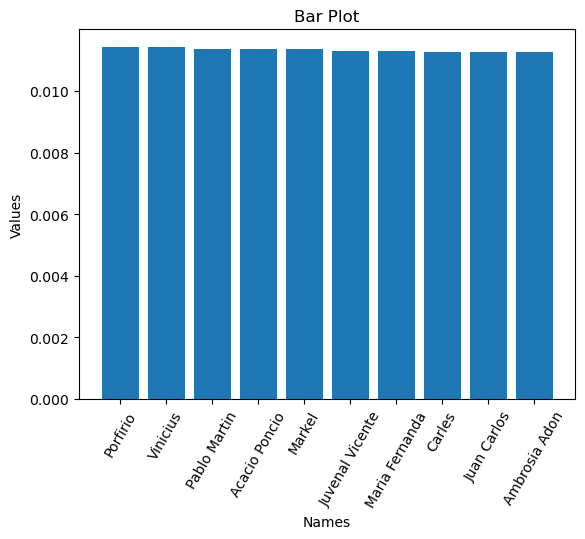

In [319]:


features, label = next(generator)
outputs = model(features).cpu()
softmax_output = Softmax(outputs.unsqueeze(0))
sorted_values, sorted_indices = torch.sort(softmax_output, descending=True)
sorted_values = sorted_values[0][:10]
sorted_indices = sorted_indices[0][:10]
mapped_list_comprehension = [Dataset.Labels2Translator[int(num)] for num in sorted_indices]


import matplotlib.pyplot as plt
plt.bar(mapped_list_comprehension, sorted_values.detach().numpy())

# Add labels and title
plt.xlabel('Names')
plt.ylabel('Values')
plt.title('Bar Plot')
# Rotate the x-labels
plt.xticks(rotation=60)
# Display the plot
plt.show()

In [320]:
Dataset.Labels2Translator[int(label)]

'Juan Carlos'